In [1]:
#importing all the libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random
import math
from IPython.display import clear_output
import sys

In [2]:
#loading H matrix from Hmatrix.mat file and converting it to numpy array
mat = scipy.io.loadmat('Hmatrix3.mat')
arr = mat['H']

In [3]:
#creating p evenly spaced
p = np.linspace(0, 1.1, 11, endpoint = False)
print(p)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [4]:
#success matrix
nsuc=np.zeros(len(p)) # Array to store success


In [5]:
colm = len(arr[0])#number of columns
row = len(arr)#number of rows
print(colm)
print(row)

12
9


In [6]:
c = np.zeros(colm) # Input of BSC Channel 
cnt = 0
nsim = 100
onlylj = 0
Lj_prev=np.zeros(colm) # For Breaking Condition
print(c)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
counter=-1
for a in p:
    counter+=1
    for b in range(nsim): # Monte-Carlo Simulation
        clear_output(wait = True)
        print(counter+(np.round((b/nsim)*100, 2))/100,"%")
        e=[]
        for z in range(colm): # noise generated
                if(random.random() < a):
                    e.append(1)
                else:
                    e.append(0)
        
        Msg_received = []
        for z in range(len(c)):  # Message generating 
            Msg_received.append( int(e[z])^int(c[z]))
        
        llr=np.zeros(colm) # log likelihood ratio
        # Loading The Message from VN to CN
        for i in range(colm): # loading log likelihood ratio of MSG
            if Msg_received[i]==1:
                if(1-a == 0):
                    llr[i]=np.inf
                elif(a==0):
                    llr[i] = -np.inf
                else:
                    llr[i]=math.log(a/(1-a)) # Log of odd in favor of zero
            else:
                if(1-a == 0):
                    llr[i]=-np.inf
                elif(a==0):
                    llr[i]=np.inf
                else:
                    llr[i]=math.log((1-a)/a)
                
        
        Mij1=np.zeros((row,colm)) # LLR Ratio's VN to CN
        for i in range((row)):
            for j in range((colm)):
                if arr[i][j]==1:  # storing LLR of VN connected to CN in matrix
                    Mij1[i][j]=llr[j]; # for first iteration
        
        Eij=np.zeros((row,colm))  # CN calculation
        for i in range(row):
            for j in range(colm):
                if Mij1[i][j]!=0: # checking whether there is any value of LLR present in matrix
                    temp_cnt=1
                    not_ii=j
                    for ii in range(colm):
                        if (ii!=not_ii) and (Mij1[i][ii]!=0):
                            not_Mij2=Mij1[i][ii]
                            temp_cnt=temp_cnt * math.tanh(not_Mij2/2)  # Probabilities passing from VN to CN
                    if(1-temp_cnt == 0):
                        Eij[i][j]=np.inf
                    elif(1+temp_cnt==0):
                        Eij[i][j]=-np.inf
                    else:
                        Eij[i][j]=math.log((1+temp_cnt)/(1-temp_cnt)) # Loading LLR of all mulitplied probabilites
                        # LLR of CN thinks that VN is 0 / CN thinks that VN is 1
        
        Li=np.zeros(colm) # Decision Boundary 
        Li = np.ndarray.tolist(Li)
        for i in range(colm):
            onlylj = 0
            for t in range(row):
                onlylj+=Eij[t][i]
            Li[i]=onlylj+llr[i] # Adding llr of all the CN->VN and llr from channel
        
        Msg_received2=np.zeros(colm)
        for i in range(colm):
            if Li[i]<=0:
                Msg_received2[i]=1
        
        if(sum(Msg_received2)==0): # If decoded message is all zeros 
            nsuc[cnt]=nsuc[cnt]+1
        else:
            counter2=-1
            for iit in range(50):
            
                Mij2=np.zeros((row,colm))
                for i in range(row):
                    for j in range(colm):
                        
                        if arr[i][j]==1:
                            temp_cnt=0
                            not_ii=i
                            for ii in range(row):
                                if (Eij[ii][j]!=0) and (ii!=not_ii):
                                    temp_cnt=temp_cnt+Eij[ii][j]                         
                            Mij2[i][j]=temp_cnt+llr[j]
                
                Eij=np.zeros((row,colm))
                for i in range(row):
                    for j in range(colm):
                        if Mij2[i][j]!=0:
                            temp_cnt=1
                            not_ii=j
                            for ii in range(colm):
                                if (ii!=not_ii) and (Mij2[i][ii]!=0):
                                    not_Mij2=Mij2[i][ii]
                                    temp_cnt=temp_cnt * math.tanh(not_Mij2/2)  
                            if(1-temp_cnt == 0):
                                Eij[i][j]=np.inf
                            elif(1+temp_cnt == 0):
                                Eij[i][j] = -np.inf
                            else:
                                Eij[i][j]=math.log((1+temp_cnt)/(1-temp_cnt))
                
                Li=np.zeros(colm)
                for i in range(colm):
                    onlylj = 0
                    for t in range(row):
                        onlylj+=Eij[t][i]
                    
                    Li[i]=onlylj+llr[i]
                if(Li.all()==Lj_prev.all()): # If LLR does not change after iteration
                    #It means that no further decoding is possible
                    break
                
                Lj_prev=Li
                Msg_received2=np.zeros(colm)
                for i in range(colm):
                    if Li[i]<=0:
                        Msg_received2[i]=1
                temp_sum = 0
                for x in Msg_received2:
                    temp_sum += x
                if(temp_sum==0): # Successfully decoded
                    nsuc[cnt]=nsuc[cnt]+1 # incrementing the counter
                    break
    cnt=cnt+1

10.99 %


Text(0, 0.5, 'Probability of success')

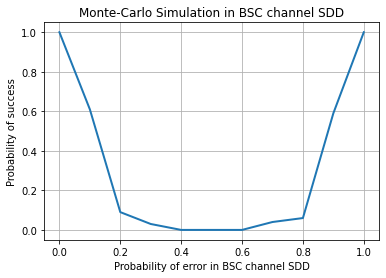

In [8]:
#plotting the graph
plt.plot(p,nsuc/nsim,linewidth = 2)
plt.grid()
plt.title("Monte-Carlo Simulation in BSC channel SDD")
plt.xlabel("Probability of error in BSC channel SDD")
plt.ylabel("Probability of success") 
